# Image Caption Generator
## A process of recognizing the context of an image and annotating it with relevant captions using deep learning, and computer vision.
### We have used ImageNet dataset pretrained model InceptionV3 to train the CNN model.
### InceptionV3 is responsible for image feature extraction.
### These extracted features will be fed to the LSTM model which in turn generates the image caption.

# CNN-LSTM Architecture
### The CNN-LSTM architecture involves using CNN layers for feature extraction on input data combined with LSTMs to support sequence prediction. 
#### CNN-LSTMs are generally used when their inputs have spatial structure, such as 
#### the **2D structure or pixels in an image or the 1D structure of words in a sentence**, paragraph, or document and also have a **temporal structure in their input** such as the order of images in a video or words in text, or require the generation of output with temporal structure such as words in a textual description.

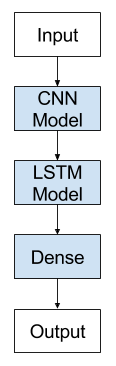

# Approach to the problem statement
### We tackle this problem using an Encoder-Decoder model.
### Here our encoder model will **combine both the encoded form of the image and the encoded form of the text caption and feed to the decoder**.
### Our model will treat CNN as the **‘image model’** and the RNN/LSTM as the **‘language model’** to encode.
### The vectors resulting from **both the encodings are then merged** and processed by a Dense layer to make a final prediction.

## We create a **merge architecture** in order to **keep the image out of the RNN/LSTM** and thus be able to train the part of the **neural network that handles images and the part that handles language separately**, using images and sentences from separate training sets. 

### In our merge model, a different representation of the image can be combined with the final RNN state before each prediction.
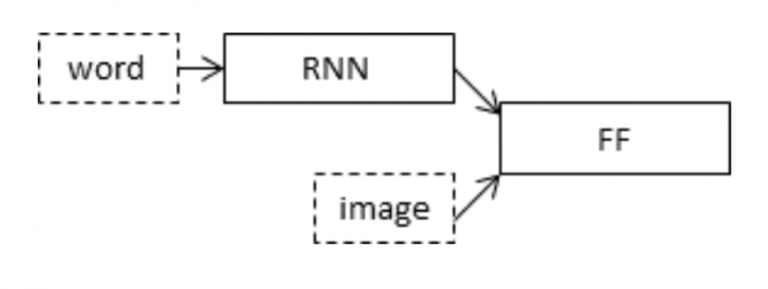
## The **merging of image features with text encodings** to a later stage in the architecture is advantageous and can **generate better quality captions with smaller layers** than the traditional inject architecture (CNN as encoder and RNN as a decoder).

## To encode our image features we will make use of **transfer learning**. There are a lot of models that we can use like VGG-16, InceptionV3, ResNet, etc.
#### Transfer learning is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task.
## CNN Image Training:
## We make use of the inceptionV3 model which has the least number of training parameters in comparison to the others and also outperforms them.
#### Inception v3 is an image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset.
## LSTM textual sequence training :
#### To encode our text sequence, we will map every word to a 200-dimensional vector. For this we use a pre-trained Glove model. 
### The basic idea behind the Glove word embedding is to derive the **relationship between the words from statistics**. Unlike the occurrence matrix, **the co-occurrence matrix tells you how often a particular word pair occurs together.** Each value tabulates how frequently words co-occur with one another in a given corpus. 
#### This mapping will be done in a separate layer after the input layer called the embedding layer.
## Approach for generating better captions:

### To generate the caption we will be using two popular methods which are Greedy Search and Beam Search. These methods will help us in picking the best words to accurately define the image.

## Greedy Search:
### An algorithm that always takes the best immediate, or local, solution while finding an answer. 

## Beam Search:
### The beam search strategy generates the translation word by word from left-to-right while keeping a fixed number (beam) of active candidates at each time step. By increasing the beam size, the translation performance can increase at the expense of significantly reducing the decoder speed.


# Step 1: - Import the required libraries 

In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Step 2: - Data loading and Pre-processing
### We will **define** all the **paths** to the files that we require and save the images id and their captions.


In [2]:
## Step 2 : Data Loading and Pre-Processing

token_path = "../input/flickr-8k/Flickr8k.token.txt"
train_images_path = '../input/flickr-8k/Flickr_8k.trainImages.txt'
test_images_path = '../input/flickr-8k/Flickr_8k.testImages.txt'
images_path = '../input/flickr8k/Images/'
glove_path = '../input/glove6b/'

doc = open(token_path,'r').read()
print(doc[:410])

### So we can see the format in which our image id’s and their captions are stored.
## Next, we create a dictionary named “descriptions” which contains the **name of the image as keys and a list of the 5 captions** for the corresponding image as values.

In [3]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)
descriptions

## Now let’s perform some basic text clean to get rid of punctuation and convert our descriptions to lowercase.

In [4]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

## Lets visualize and example image

In [5]:
pic = '1003163366_44323f5815.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1003163366_44323f5815']


## Next, we create a vocabulary of unique words present across all the 8000 * 5(40000) image captions in the dataset.

## We have 8828 unique words across all the 40000 image captions.

In [6]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

## Now let’s save the image id’s and their new cleaned captions in the same format as the token.txt file

In [7]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

## Next, we load all the 6000 training image_id's in a variable train

In [8]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

## Now we save all the training and testing images in train_img and test_img lists respectively:

In [9]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

## Now, we will load the descriptions of the training images into a dictionary. However, we will add two tokens in every capation, which are **startseq** and **endseq**.


In [11]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)
train_descriptions


## Crate a list of all the training captions

In [12]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
all_train_captions


## To make our model more robust, we will reduce our vocabulary to only those words which occur atleast 10 times in the entire corpus.

In [13]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))
vocab

## Now, we will create two dictionaries to map words to an index and vice versa. Also, we will append 1 to our vocabulary since we append 0 to make all the captions of equal lengths

In [14]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [15]:
wordtoix

#### Hence we now have a vocab size of 1660.

## We also need to find out what **maximum length of a caption** can be, since we can't have captions of arbitary length.
##### So for this we take the maximum length of a caption from our training dataset.

In [16]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

# Step 3: Glove Embeddings

#### Word vectors map words to a vector space, where similar words are clustered together and different words are separated.
#### The basic premise behind Glove is that we can derive sematic relationships between words from the coouucrence matrix.

#### For our model, we will map all the 38-word long caption to a 200-dimension vector using Glove.

In [17]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
embeddings_index

#### Now, we make metrix of shape(1660,220) consisting of our vocabulary and the 200-d vector.

In [18]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Step 4 : Model building and Training

### An approach we have adopted is transfer learning using Inception V-3 network which is pre-trained on the Image-Net dataset.

In [ ]:
# model = In`ceptionV3(weights='imagenet')

In [19]:
model = InceptionV3(weights='../input/imagecaptiongeneratorweights/inception_v3_weights_tf_dim_ordering_tf_kernels.h5')

In [20]:
model_new = Model(model.input, model.layers[-2].output)

### Since we are using Inception V-3 , we need to pre-process our inputs before feeding it into the model.
#### Hence, we need to defince a preprocess function to reshape the images(299 x 299) and feed the preprocess_input() function.

In [21]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

## Now, we can go ahead with training and testing images i.e we can extract the images vectors of shape (2048 ,)

In [22]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

## Now let’s define our model.

### We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:

* Processing the sequence from the text
* Extracting the feature vector from the image
* Decoding the output using softmax by concatenating the above two layers

#### The Photo Feature Extractor model expects input photo features to be a vector of 2,048 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.

#### The Sequence Processor model expects input sequences with a pre-defined length (38 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.

#### Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

#### The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

In [23]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


### Input_3 is the partial caption of max length 38 which is fed into the embedding layer. This is where the words are mapped to the 200-d Glove embedding. It is followed by a dropout of 0.5 to avoid overfitting. This is then fed into the LSTM for processing the sequence.

### Input_2 is the image vector extracted by our InceptionV3 network. It is followed by a dropout of 0.5 to avoid overfitting and then fed into a Fully Connected layer.

### Both the Image model and the Language model are then concatenated by adding and fed into another Fully Connected layer. The layer is a softmax layer that provides probabilities to our 1660 word vocabulary.


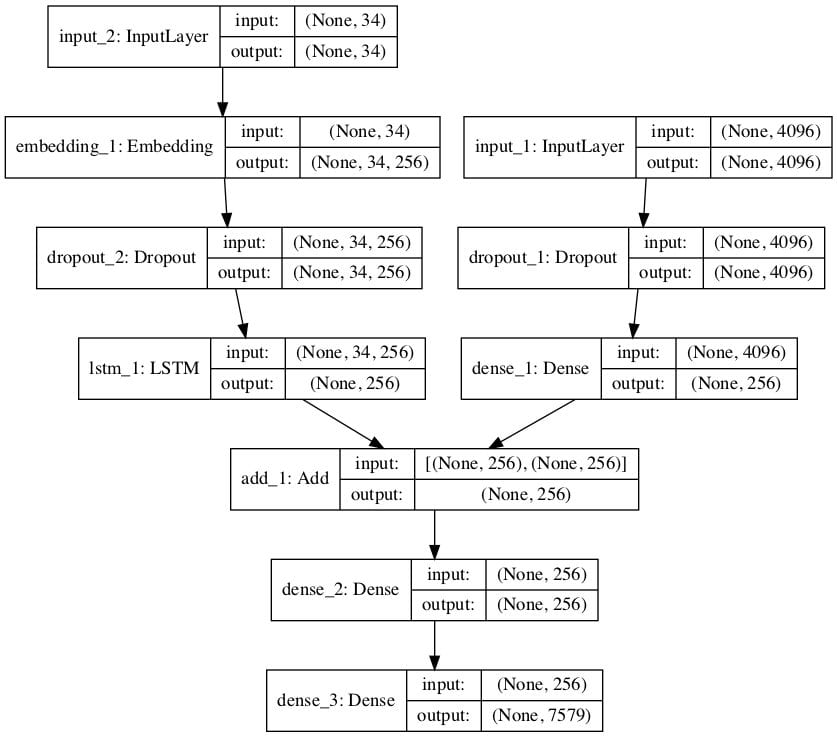

### Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer, thus called as dense. Dense Layer is used to classify image based on output from convolutional layers.
#### Each Layer in the Neural Network contains neurons, which compute the weighted average of its input and this weighted average is passed through a linear function, called as an “Softmax activation function” for LSTM and "Relu activation function” a non-linear function for Image processing. Result of this activation function is treated as output of that neuron. In similar way, the process is carried out for all neurons of all layers.
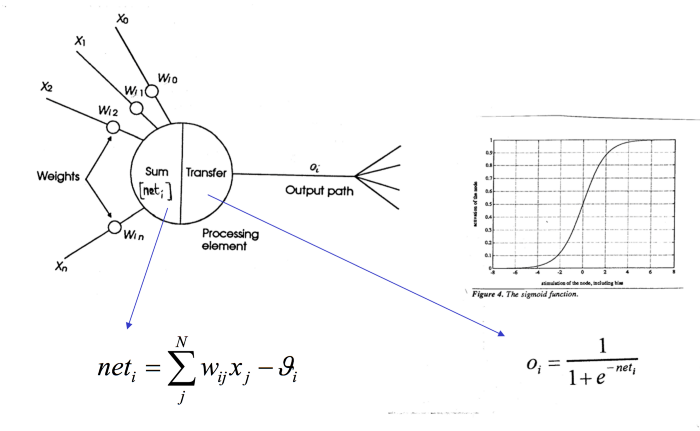

# Step 5 : Model Training

#### Before training the model we need to keep in mind that we do not want to retrain the weights in our embedding layer (pre-trained Glove vectors).

In [24]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

## Next, compile the model using Categorical_Crossentropy as the Loss function and Adam as the optimizer.

#### **Categorical crossentropy** is a loss function that is used in multi-class classification tasks. These are tasks where an example can only belong to one out of many possible categories, and the model must decide which one. Formally, it is designed to quantify the difference between two probability distributions.

#### **Adam optimizer** involves a combination of two gradient descent methodologies:
##### **Momentum**: This algorithm is used to accelerate the gradient descent algorithm by taking into consideration the 'exponentially weighted average' of the gradients.
##### Using averages makes the algorithm converge towards the minima in a faster pace.

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

### Since our dataset has 6000 images and 40000 captions we will create a function that can train the data in batches.


In [26]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key +'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0


### Now, let's train our model with for 30 epochs with a batch_size of 10 and 2000 steps per epoch.

In [27]:
epochs = 30
batch_size = 10
steps = len(train_descriptions)//batch_size
callback = EarlyStopping(monitor='loss', patience=5)
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1,callbacks=[callback])
model.save("model.h5")

In [ ]:
model.save("/kaggle/working/model_2.h5")

In [ ]:
from tensorflow.keras.models import load_model
modela = load_model("..input/dataset_name/model_name.h5")

## Step 6: Greddy and Beam Search

## Greedy Search
### As the model generates a 1660 long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called Greedy Search.



In [32]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

## Beam Search:
### Beam Search is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we encounter ‘endseq’ or reach the maximum caption length.


In [29]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

## Step 7:- Evaluation


### Let’s now test our model on different images and see what captions it generates. We will also look at the different captions generated by Greedy search and Beam search with different k values.

### First, we will take a look at the example image we saw at the start of the article. We saw that the caption for the image was ‘A black dog and a brown dog in the snow’. Let’s see how our model compares

In [30]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path + pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [31]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))